# TP2 - Retrieval Augmented Generation

Dans ce TP nous allons construire un système RAG complet : base de connaissance, vectorisation et appel avec un modèle de langage.

Certaines fonctions seront réutilisées dans les prochaines séances, nous encourageons donc la définition de fonction générale, optimisée et robuste. Il est à garder en tête que ce notebook n'a qu'une portée pédagogique et n'est pas forcément à jour puisque le domaine évolue rapidement.

Dans ce TP nous cherchons à apporter des connaissances Machine Learning, bien que le modèle en ait largement, en utilisant des cours au format PDF à notre disposition. 


## Constitution de la base de connaissance

Pour construire un RAG, il faut commencer par une base de connaissance. Elle sera composée dans notre cas de document PDF. Nous allons commencer par extraire les informations texte contenue dans les documents.

**Consigne** : À partir des fichiers disponible, construire une fonction `pdf_parser` qui prend en paramètre le nom du fichier et qui renvoie le texte associé. On utilisera la classe [`PyPDFLoader`](https://python.langchain.com/docs/how_to/document_loader_pdf/#simple-and-fast-text-extraction) et sa méthode `load` pour charger le document.


In [1]:
from langchain_community.document_loaders import PyPDFLoader

def pdf_parser(file_path: str):
    loader = PyPDFLoader(file_path=file_path)
    return loader.load()

**Consigne** : Utiliser la fonction `pdf_parser` pour charger le fichier 'ML.pdf' puis inspecter son contenu.

In [2]:
ml_doc = pdf_parser("ML.pdf")
print(ml_doc[5])

page_content='Chapitre 1
Introduction au Machine Learning
Les termes d’intelligence artificielle (IA) et Machine Learning (ML) sont fréquemment confondu et
leur hiérarchie n’est pas toujours clair. Unalgorithme est une séquence d’instructions logique ordonnée
pour répondre explicitement à un problème. Par exemple, une recette de cuisine est un algorithme, mais
tous les algorithmes ne sont pas des recettes de cuisine. Un algorithme d’intelligence d’artificielle est un
algorithme, mais il n’est pas explicitement construit pour répondre à un problème : il va s’adapter. S’il
s’appuie sur des données, alors on parle d’algorithme de Machine Learning1.
Le terme d’intelligence artificielle vient de la conférence de Dartmouth en 1957 où l’objectif était de
copier le fonctionnement des neurones. Mais les concepts d’intelligence artificielle était déjà proposé par
Alan Turing, et la méthode des moindres carrés de Legendre (la fameuse tendance linéaire dans Excel)
date de bien avant 1957. Depuis, 

Nous avons du texte et des métadonnées. Nous commençerons par nous concentrer sur le texte. Pour qu'il puisse être digérer par le RAG, nous devons le découper en plusieurs *chunk*. La classe [`CharacterTextSplitter`](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.CharacterTextSplitter.html) permet de réaliser cette opération.

In [3]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

texts = text_splitter.split_documents(documents=ml_doc)
print(f"Il y a {len(texts)} chunks.")

Il y a 1471 chunks.


**Consigne** : Après avoir inspecté le contenu de la variable *texts*, afficher la distribution de la longueur des chunks.

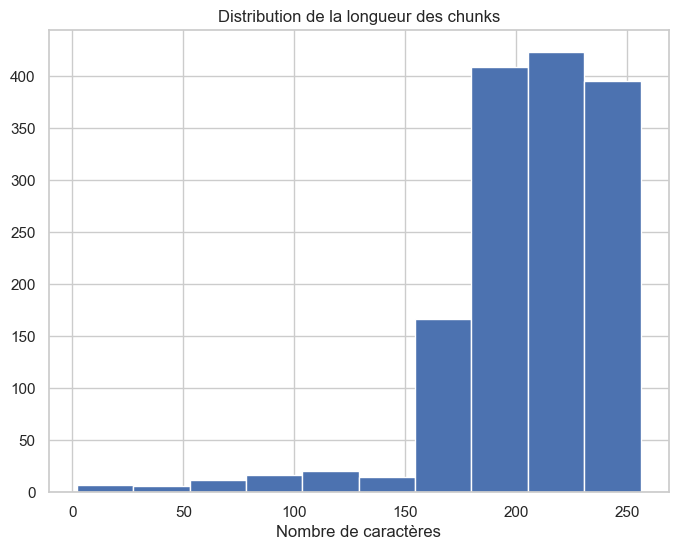

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid")


length = np.array([len(doc.page_content) for doc in texts])

plt.figure(figsize=(8, 6))
plt.hist(length)
plt.title("Distribution de la longueur des chunks")
plt.xlabel("Nombre de caractères")
plt.show()

Nous observons des chunks avec très peu de caractères. Inspecter les contenus des documents avec moins de 100 caractères et noter les améliorations possibles.

In [5]:
for doc in texts:
    if len(doc.page_content) < 100:
        print(doc.page_content)
        print("-" * 30)

INTRODUCTION AU MACHINE LEARNING
2022-2026
Théo Lopès-Quintas
------------------------------
vue un peu plus complète du domaine, ainsi qu’un aperçu plus récent des développements en cours.
2
------------------------------
3. À condition que l’algorithme soit performant.
7
------------------------------
Pour essayer de comprendre ce passage, faisons un exercice :
4. Voir l’équation (2.3).
8
------------------------------
11
------------------------------
le résultat, on peut vérifier la cohérence de la formule avec un exercice.
15
------------------------------
valeur moyenne. La vision est donc bien complémentaire à celle de laRMSE.
17
------------------------------
• FP : Faux positif - une baisse identifiée comme une hausse
28
------------------------------
L’idée est de partitionner l’espace engendré parD, dont voici la procédure à chaque étape :
33
------------------------------
définir ce que l’on appelle intuitivementla meilleure coupure.
34
------------------------------
Devant

Nous avons à présent un ensemble de chunk, il nous reste à construire l'embedding pour stocker toute ces informations. Nous faisons les choix suivants :
* Nous utiliserons l'embedding [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) pour sa taille et son entraînement spécifique à notre tâche
* Nous utiliserons le *vector store* [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss/) puisque nous l'avons couvert en cours.
* Nous récupérerons les trois chunks les plus proches, pour commencer

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import os

os.environ['USE_TF'] = 'false'
os.environ['USE_TORCH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectordb = FAISS.from_documents(texts, embedding_model)
n_doc_to_retrieve = 3
retriever = vectordb.as_retriever(search_kwargs={"k": n_doc_to_retrieve})

Notre base de connaissance est réalisée ! Passons maintenant à l'augmentation du modèle de langage.

## Génération

Pour cette étape, il nous reste à définir le modèle de langage et comment nous allons nous adresser à lui.

**Consigne** : Définir la variable *model* à partir de la classe [OllamaLLM](https://python.langchain.com/api_reference/ollama/llms/langchain_ollama.llms.OllamaLLM.html#ollamallm) et du modèle de votre choix.

In [7]:
from langchain_ollama import OllamaLLM

model = OllamaLLM(model="gemma3:4b")

**Consigne** : À l'aide de la classe [PromptTemplate](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html#langchain_core.prompts.prompt.PromptTemplate) et en s'inspirant éventuellement de [cet exemple](https://smith.langchain.com/hub/rlm/rag-prompt), définir un template de prompt qui aura deux *input_variable* : 'context' et 'question'.

In [8]:
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Answer in the language of the question asked.

    Question: {question}
    Context:\n{context}
    Answer:
    """,
    input_variables=["context", "question"]
)

Pour construire la chaîne de RAG, LangChain utilise le [LangChain Expression Language (LCEL)](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel), voici dans notre cas comment cela se traduit :

In [9]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_template
    | model
    | StrOutputParser()
)

Une fois la chaîne définie, nous pouvons lui poser des questions :

In [10]:
query = "Quelle est la citation d'Alan Turing ?"
result = rag_chain.invoke(query)
print("Answer:", result)

Answer: Nous ne pouvons qu’avoir un aperçu du futur, mais cela suffit pour comprendre qu’il y a beaucoup à faire.
— Alan Turing (1950)


LangChain ne permet pas nativement d'afficher quels chunks ont été utilisé pour produire la réponse, ni le score de similarité. Pour le faire, nous allons utiliser directement FAISS.

**Consigne** : À l'aide de la méthode [`similarity_search_with_score`](https://python.langchain.com/v0.2/docs/integrations/vectorstores/llm_rails/#similarity-search-with-score) de `FAISS`, afficher les trois documents utilisé dans le RAG.

In [11]:
results_with_scores = vectordb.similarity_search_with_score(query, k=n_doc_to_retrieve)

for doc, score in results_with_scores:
    print(f"Similarity Score: {score:.4f}")
    print(f"Document Content: {doc.page_content}")
    print("-" * 50)

Similarity Score: 0.5376
Document Content: s’entraîneront, propageant ainsi les biais des premiers. Évidemment les usages malveillants malgré un
travail sur la sécurité et la toxicité toujours plus important.
Finalement, la fameuse citation d’Alan Turing est plus que jamais d’actualité.
--------------------------------------------------
Similarity Score: 0.6169
Document Content: Cadre et approche du cours
Alan Turing publieComputing Machinery and Intelligenceen 1950 [Tur50], qui deviendra un article
fondamental pour l’intelligence artificielle. Une citation devenue célèbre a motivé l’écriture de ce cours :
--------------------------------------------------
Similarity Score: 0.6388
Document Content: Nous ne pouvons qu’avoir un aperçu du futur, mais cela suffit pour comprendre qu’il y a
beaucoup à faire.
— Alan Turing (1950)
C’est par cette vision des années 1950 que nous nous proposons de remonter le temps et de découvrir
--------------------------------------------------


Nous avons finalement bien défini notre premier RAG !

## Amélioration de notre RAG

Mais nous pouvons faire mieux, notamment afficher la source dans la génération pour que l'utilisateur puisse vérifier et mesurer les performances de notre RAG. Une fois que nous aurons réalisé ces deux améliorations, alors nous pourrons modifier plusieurs points techniques spécifique et mesurer l'apport en performance.

### Exploiter les méta-données

Nous avons utilisé la classe `PyPDFLoader` qui charge chaque page dans un document. Nous avons largement utilisé le contenu *page_content* mais l'attribut *metadata* contient deux informations qui nous intéressent : *source* et *page*. 

**Consigne** : Modifier la fonction `format_doc` pour qu'elle prenne en paramètre une liste de document LangChain puis qu'elle affiche la source et la page en plus de seulement le contenu texte.

In [12]:
def format_docs(docs):
    formatted = []
    for doc in docs:
        source = doc.metadata.get("source", "unknown")
        page = doc.metadata.get("page", "unknown")
        content = doc.page_content.strip()
        formatted.append(f"[Source: {source}, Page: {page+1}]\n{content}")
    return "\n\n".join(formatted)

Maintenant que nous passons des informations sur les métadonnées, il faut s'assurer que le modèle de langage les utilises.

**Consigne** : Modifier le prompt template défini plus tôt pour intégrer cette règle.

In [13]:
prompt_template = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks. 
    Use the following retrieved pieces of context (with source and page information) to answer the question. 
    If you don't know the answer, just say that you don't know. Answer in the same language as the question.
    When possible, cite the source and page in your answer. 

    Question: {question}
    Context:\n{context}
    Answer:
    """,
    input_variables=["context", "question"]
)

Testons à présent avec la même question sur une nouvelle chaîne RAG prenant en compte nos améliorations.

**Consigne** : Définir un nouveau RAG prenant en compte les informations des méta-données, puis poser la même question.

In [14]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_template
    | model
    | StrOutputParser()
)

query = "Quelle est la citation d'Alan Turing ?"
result = rag_chain.invoke(query)
print("Answer:", result)

Answer: Selon ML.pdf, page 92, la citation d'Alan Turing est : « Nous ne pouvons qu’avoir un aperçu du futur, mais cela suffit pour comprendre qu’il y a beaucoup à faire. »


C'est ce que nous souhaitions obtenir ! Mais nous pourrions avoir un format un peu plus structuré et moins libre. Pour cela, nous allons modifier notre système pour qu'il renvoie des JSON !
Commençons par modifier le template de prompt pour lui donner les instructions :

In [15]:
prompt_template = PromptTemplate(
  template="""
    You are an assistant for question-answering tasks, use the retrieved context to answer the question.  Each piece of context includes metadata (source + page).
    If you don’t know the answer, respond with: {{"answer": "I don't know", "sources": []}}
    Otherwise, return your answer in JSON with this exact structure:
    {{
      "answer": "your answer here",
      "sources": ["source:page", "source:page"]
    }}
    Rules:
    - Answer in the same language as the question.
    - Always include the sources (source:page).
    - Never add extra fields.

    Question: {question}
    Context:\n{context}
    Answer:
    """,
  input_variables=["context", "question"]
)

Puisque nous demandons ici de répondre par exemple : '['ML.pdf:91"], nous allons lui faciliter la tâche en modifiant la fonction `format_docs`.

**Consigne** : Modifier la fonction `format_docs` pour prendre en compte le formattage 'source:page'.

In [16]:
def format_docs(docs):
    formatted = []
    for doc in docs:
        source = doc.metadata.get("source", "unknown")
        page = doc.metadata.get("page", "unknown")
        content = doc.page_content.strip()
        formatted.append(f"[{source}:{page+1}]\n{content}")
    return "\n\n".join(formatted)

Si nous souhaitons obtenir un JSON, ou un dictionnaire, en sortie du modèle, nous devons modifier la chaîne RAG définie précédemment.

**Consigne** : Remplacer la fonction [`JsonOutputParser`](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.json.JsonOutputParser.html) à la place de [`StrOutputParser`](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.string.StrOutputParser.html#langchain_core.output_parsers.string.StrOutputParser) puis tester la nouvelle chaîne RAG avec la même question.

In [17]:
from langchain_core.output_parsers import JsonOutputParser


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_template
    | model
    | JsonOutputParser()
)

query = "Quelle est la citation d'Alan Turing ?"
result = rag_chain.invoke(query)
print("Answer:", result)

Answer: {'answer': 'Nous ne pouvons qu’avoir un aperçu du futur, mais cela suffit pour comprendre qu’il y a beaucoup à faire.', 'sources': ['ML.pdf:2']}


C'est mieux ! Il nous reste à présent à mesurer la performance de notre système.


### Mesurer les performances

Nous avons défini manuellement plusieurs questions dont les réponses sont contenus dans le cours dans le fichier JSON *eval_dataset*.

In [18]:
import json
with open("eval_dataset.json", "r", encoding="utf-8") as file:
    eval_dataset = json.load(file)

print(eval_dataset[0])

{'question': "Qu'est-ce qu'un algorithme ?", 'answer': 'Un algorithme est une séquence d’instructions logique ordonnée pour répondre explicitement à un problème.', 'sources': 'ML.pdf:6'}


Il sera probablement difficile de mesurer la performance de manière frontale. Ainsi, nous optons pour une méthodologie *LLM as a Judge*.

**Consigne** : Définir une fonction `evaluate_rag` qui prend en paramètre une chaîne RAG et un dataset pour évaluation. La fonction renverra une liste de dictionnaire avec pour clés :
* *question* : la question posée
* *expected_answer* : la réponse attendue
* *predicted_answer* : la réponse obtenue
* *expected_sources* : la ou les sources attendues
* *predicted_sources* : la ou les sources obtenues

In [19]:
def evaluate_rag(rag_chain, dataset):
    results = []
    for example in dataset:
        prediction = rag_chain.invoke(example["question"])

        results.append({
            "question": example["question"],
            "expected_answer": example["answer"],
            "predicted_answer": prediction["answer"],
            "expected_sources": example["sources"],
            "predicted_sources": prediction["sources"]
        })
    return results

**Consigne** : Tester la fonction précédente avec les trois premières questions puis afficher le résultat sous la forme d'un dataframe pandas.

In [20]:
results = evaluate_rag(rag_chain, dataset=eval_dataset[:3])
print(results)

[{'question': "Qu'est-ce qu'un algorithme ?", 'expected_answer': 'Un algorithme est une séquence d’instructions logique ordonnée pour répondre explicitement à un problème.', 'predicted_answer': "Un algorithme est un objet dont nous supposerons l'existence, et dont la description sera le cœur des prochains chapitres.", 'expected_sources': 'ML.pdf:6', 'predicted_sources': ['ML.pdf:6', 'ML.pdf:134']}, {'question': "Qu'est-ce qu'un hackathon ?", 'expected_answer': 'Un hackathon en Machine Learning est une compétition entre data-scientists (ou étudiants) dont le but est de trouver la meilleure manière de répondre à une tâche donnée.', 'predicted_answer': "I don't know", 'expected_sources': 'ML.pdf:10', 'predicted_sources': []}, {'question': "Quel est l'inconvénient de la méthode Leave-One-Out Cross-Validation ?", 'expected_answer': 'L’un des inconvénients majeur est que cela peut devenir très long et très coûteux en opération de calcul puisqu’il faut entraîner n fois l’algorithme sur presqu

Nous sommes capable d'obtenir un ensemble de réponse de la part d'un modèle avec un RAG, il nous reste à mettre en place le juge.

**Consigne** : Définir un prompt pour décrire le rôle du juge.

In [21]:
judge_prompt = PromptTemplate(
    template = """
    You are an evaluator. Your task is to compare a student's answer with the reference answer. 
    The student answer may still be valid even if it is phrased differently.

    Question: {question}
    Reference Answer: {expected_answer}
    Expected Sources: {expected_sources}

    Student Answer: {predicted_answer}
    Student Sources: {predicted_sources}

    Evaluation Instructions:
    - If the student's answer correctly matches the meaning of the reference answer, mark it as CORRECT. 
    - If it is wrong or missing important details, mark it as INCORRECT.
    - For sources, check if the student listed at least the expected sources. Extra sources are allowed.
    - Return your judgment strictly as JSON:
    {{
        "answer_correct": true/false,
        "sources_correct": true/false,
    }}
    """,
    input_variables=[
        "question",
        "expected_answer",
        "predicted_answer",
        "expected_sources",
        "predicted_sources",
    ]
)

**Consigne** : Définir une chaîne pour le juge, de la même manière que le RAG : prompt --> model --> JSONParser

In [22]:
judge_model = OllamaLLM(model="gemma3:4b")
json_parser = JsonOutputParser()

judge_chain = judge_prompt | judge_model | JsonOutputParser()

**Consigne** : Modifier la fonction `evaluate_rag` pour qu'elle note directement la performance du modèle et renvoie sous forme d'un dataframe pandas les résultats. On implémentera également des mesures temporelles pour le RAG et le juge, ainsi que des blocs *try...except...* pour ne pas bloquer l'exécution de toutes les requêtes si une renvoie une erreur.
Pour pouvoir suivre l'avancement de l'évaluation, on utilisera la barre de progression tqdm.

In [23]:
from tqdm import tqdm
import time
import pandas as pd


def evaluate_rag(rag_chain, dataset, judge_chain):
    """
    Evaluate a RAG chain against a dataset using a judge LLM.

    Args:
        rag_chain: LangChain RAG chain.
        dataset: List of dicts with 'question', 'answer', 'sources'.
        judge_chain: LangChain judge chain that outputs JSON with 'answer_correct', 'sources_correct', 'explanation'.

    Returns:
        pandas.DataFrame with predictions, judgment, and timings.
    """
    results = []

    iterator = tqdm(dataset, desc="Evaluating RAG", unit="query")

    for example in iterator:
        rag_start = time.time()
        try:
            prediction = rag_chain.invoke(example["question"])
        except Exception as e:
            prediction = {"answer": "", "sources": []}
            print(f"[RAG ERROR] Question: {example['question']} | {e}")
        rag_end = time.time()

        judge_input = {
            "question": example["question"],
            "expected_answer": example["answer"],
            "predicted_answer": prediction.get("answer", ""),
            "expected_sources": example["sources"],
            "predicted_sources": prediction.get("sources", []),
        }

        judge_start = time.time()
        try:
            judgment = judge_chain.invoke(judge_input)
        except Exception as e:
            judgment = {"answer_correct": False, "sources_correct": False, "explanation": f"Judge error: {e}"}
            print(f"[JUDGE ERROR] Question: {example['question']} | {e}")
        judge_end = time.time()

        results.append({
            **judge_input,
            **judgment,
            "rag_time": rag_end - rag_start,
            "judge_time": judge_end - judge_start,
            "total_time": judge_end - rag_start
        })
    
    return pd.DataFrame(results)


**Consigne** : Utiliser cette fonction sur les trois premières question du dataset d'évaluation.

In [24]:
results = evaluate_rag(rag_chain, dataset=eval_dataset[:10], judge_chain=judge_chain)
results

Evaluating RAG: 100%|██████████| 10/10 [00:46<00:00,  4.64s/query]


,question,expected_answer,predicted_answer,expected_sources,predicted_sources,answer_correct,sources_correct,rag_time,judge_time,total_time
0,Qu'est-ce qu'un algorithme ?,Un algorithme est une séquence d’instructions ...,Nous ne discuterons pas d’algorithmes en parti...,ML.pdf:6,[ML.pdf:6],False,True,2.782175,1.656888,4.439065
1,Qu'est-ce qu'un hackathon ?,Un hackathon en Machine Learning est une compé...,I don't know,ML.pdf:10,[],False,False,1.868308,1.657052,3.525366
2,Quel est l'inconvénient de la méthode Leave-On...,L’un des inconvénients majeur est que cela peu...,L'inconvénient de la méthode Leave-One-Out Cro...,ML.pdf:10,"[ML.pdf:10, ML.pdf:128]",True,True,4.339367,1.844820,6.184189
3,Qu'est-ce que la régression polynomiale ?,Une régression polynomiale est une régression ...,Une régression polynomiale est une régression ...,ML.pdf:21,[ML.pdf:21],True,True,3.342725,1.751531,5.094258
4,What is exercise 3.5 about ?,Mail classification,I don't know,ML.pdf:30,[],False,False,2.151726,1.553353,3.705080
5,Quel est l'autre nom du bagging ?,La solution donne son nom à la section : nous ...,Le bagging est également connu sous le nom d’a...,ML.pdf:39,"[ML.pdf:40, ML.pdf:68]",True,True,2.952315,1.646025,4.598341
6,Qu'est-ce qu'une souche en Machine Learning ?,Les weak learners d’AdaBoost sont appelés des ...,"En Machine Learning, une souche (ou lineage) f...",ML.pdf:42,[ML.pdf:113],False,True,4.658800,1.877533,6.536340
7,Quelle sont les trois propriétés mathématiques...,"Indiscernabilité, symétrie et sous-additivité",I don't know,ML.pdf:51,[],False,False,2.128439,1.583463,3.711939
8,Pourquoi KMeans a été introduit ?,Kmeans++ : un meilleur départ\nSuivre cette mé...,I don't know,ML.pdf:54,[],False,False,1.878088,1.763518,3.641612
9,Dans quel article a été introduit le lemme de ...,Cette similitude est expliquée par le titre de...,Le lemme de Johnson-Lindenstrauss a été introd...,ML.pdf:63,[ML.pdf:64],True,True,3.118761,1.801741,4.920507


**Consigne** : A partir des résultats précédents, donner des statistiques de performance du modèle.

In [25]:
accuracy = results["answer_correct"].astype(int).mean()
source_accuracy = results["sources_correct"].astype(int).mean()
avg_rag_time = results["rag_time"].mean()
avg_judge_time = results["judge_time"].mean()
avg_total_time = results["total_time"].mean()

print(f"Accuracy: {100 * accuracy:.2f}%")
print(f"Accuracy source: {100 * source_accuracy:.2f}%")
print(f"RAG time (avg): {avg_rag_time:.2f}s")
print(f"Judge time (avg): {avg_judge_time:.2f}s")
print(f"Total time (avg): {avg_total_time:.2f}s")

Accuracy: 40.00%
Accuracy source: 60.00%
RAG time (avg): 2.92s
Judge time (avg): 1.71s
Total time (avg): 4.64s


## Pour aller plus loin

Nous avons plusieurs axes d'améliorations, de manière non exhaustive :
* Une meilleure récupération du texte dans le PDF : par exemple utiliser [Docling](https://python.langchain.com/docs/integrations/document_loaders/docling/) ?
* Une meilleure manière de découper en *chunk* le texte : par exemple utiliser [RecursiveCharacterTextSplitter](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#recursivecharactertextsplitter), ou changer la taille des chunks...
* Un meilleur modèle d'embedding : voir le [leaderboard](https://huggingface.co/spaces/mteb/leaderboard) des embeddings
* Un meilleur retrieval : meilleure méthode pour chercher, par exemple [MMR](https://python.langchain.com/v0.2/docs/how_to/example_selectors_mmr/)
* De meilleurs prompt
* Une meilleure mesure de performance : plus de questions par exemple

Nous encourageons l'étudiant à tester la ou les améliorations qu'ils souhaitent faire et surtout que les apports soit mesurés séparemment. On encourage également d'utiliser ses propres documents et son propre benchmark.
Pour accélérer encore un peu l'évaluation, on propose une version asynchrone de la fonction d'évaluation :

In [26]:
import asyncio
from tqdm.asyncio import tqdm_asyncio

async def evaluate_rag_async(rag_chain, dataset, judge_chain, max_concurrency=5):
    """
    Async evaluation of a RAG chain against a dataset using a judge LLM.
    """
    results = []
    semaphore = asyncio.Semaphore(max_concurrency)

    async def process_example(example):
        async with semaphore:
            rag_start = time.time()
            try:
                prediction = await rag_chain.ainvoke(example["question"])
            except Exception as e:
                prediction = {"answer": "", "sources": []}
                print(f"[RAG ERROR] Question: {example['question']} | {e}")
            rag_end = time.time()

            judge_input = {
                "question": example["question"],
                "expected_answer": example["answer"],
                "predicted_answer": prediction.get("answer", ""),
                "expected_sources": example["sources"],
                "predicted_sources": prediction.get("sources", []),
            }

            judge_start = time.time()
            try:
                judgment = await judge_chain.ainvoke(judge_input)
            except Exception as e:
                judgment = {"answer_correct": False, "sources_correct": False, "explanation": f"Judge error: {e}"}
                print(f"[JUDGE ERROR] Question: {example['question']} | {e}")
            judge_end = time.time()

            results.append({
                **judge_input,
                **judgment,
                "rag_time": rag_end - rag_start,
                "judge_time": judge_end - judge_start,
                "total_time": judge_end - rag_start
            })

    tasks = [process_example(example) for example in dataset]
    for f in tqdm_asyncio.as_completed(tasks, desc="Evaluating RAG", total=len(dataset)):
        await f

    return pd.DataFrame(results)
